# JAX 101 - 08 Stateful Computations
Link to the original JAX tutorial: https://jax.readthedocs.io/en/latest/jax-101/07-state.html

## Part 0 - Data Owner Setup

In [48]:
# Import the necessary libraries
import syft as sy
sy.requires(">=0.8,<0.9")

import jax
import jax.numpy as jnp
import numpy as np

✅ The installed version of syft==0.8.1b3 matches the requirement >=0.8 and the requirement <0.9


In [49]:
# Launch the domain
node = sy.orchestra.launch(name="test-domain-1", reset=True, dev_mode=True)
data_owner_client = node.login(email="info@openmined.org", password="changethis")

SQLite Store Path:
!open file:///var/folders/sz/hkfsnn612hq56r7cs5rd540r0000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite



## Part 1 - Data Scientist

In [50]:
# Register a client to the domain
data_scientist_client = node.client
data_scientist_client.register(name="Jane Doe", email="jane@caltech.edu", password="abc123", institution="Caltech", website="https://www.caltech.edu/")
data_scientist_client.login(email="jane@caltech.edu", password="abc123")

<SyftClient - test-domain-1 <7bca415d13ed4ec881f0d0aede098dbb>: PythonConnection>

In [51]:
# Create a function for code execution
# ATTENTION: ALL LIBRARIES USED SHOULD BE DEFINED INSIDE THE FUNCTION CONTEXT!!!

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def counter_1():
    import jax

    class Counter:
        """A simple counter."""

        def __init__(self):
            self.n = 0

        def count(self) -> int:
            """Increments the counter and returns the new value."""
            self.n += 1
            return self.n

        def reset(self):
            """Resets the counter to zero."""
            self.n = 0


    counter = Counter()

    for _ in range(3):
        print(counter.count())

    counter.reset()
    fast_count = jax.jit(counter.count)

    for _ in range(3):
        print(fast_count())
        

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def counter_2():    
    import jax
    from typing import Tuple

    CounterState = int

    class CounterV2:

        def count(self, n: CounterState) -> Tuple[int, CounterState]:
            # You could just return n+1, but here we separate its role as 
            # the output and as the counter state for didactic purposes.
            return n+1, n+1

        def reset(self) -> CounterState:
            return 0

    counter = CounterV2()
    state = counter.reset()

    for _ in range(3):
        value, state = counter.count(state)
        print(value)
        
    state = counter.reset()
    fast_count = jax.jit(counter.count)

    for _ in range(3):
        value, state = fast_count(state)
        print(value)
        
        
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def linear_regression():
    import syft as sy
    import jax
    import jax.numpy as jnp
    from typing import NamedTuple

    # @sy.serializable(["weight", "bias"])
    # class Params(NamedTuple):
    #     weight: jnp.ndarray
    #     bias: jnp.ndarray


    def init(rng) -> tuple[jnp.ndarray, jnp.ndarray]:
        """Returns the initial model params."""
        weights_key, bias_key = jax.random.split(rng)
        weight = jax.random.normal(weights_key, ())
        bias = jax.random.normal(bias_key, ())
        return weight, bias


    def loss(weight: jnp.ndarray, bias: jnp.ndarray, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
        """Computes the least squares error of the model's predictions on x against y."""
        pred = weight * x + bias
        return jnp.mean((pred - y) ** 2)


    LEARNING_RATE = 0.005

    @jax.jit
    def update(params: tuple[jnp.ndarray, jnp.ndarray], x: jnp.ndarray, y: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
        """Performs one SGD update step on params using the given data."""
        weight, bias = params
        grad = jax.grad(loss)(weight, bias, x, y)

        # If we were using Adam or another stateful optimizer,
        # we would also do something like
        # ```
        # updates, new_optimizer_state = optimizer(grad, optimizer_state)
        # ```
        # and then use `updates` instead of `grad` to actually update the params.
        # (And we'd include `new_optimizer_state` in the output, naturally.)

        new_params = jax.tree_map(
            lambda param, g: param - g * LEARNING_RATE, params, grad)

        return new_params
    
    import matplotlib.pyplot as plt

    rng = jax.random.PRNGKey(42)

    # Generate true data from y = w*x + b + noise
    true_w, true_b = 2, -1
    x_rng, noise_rng = jax.random.split(rng)
    xs = jax.random.normal(x_rng, (128, 1))
    noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
    ys = xs * true_w + true_b + noise

    # Fit regression
    weight, bias = init(rng)
    for _ in range(1000):
        weight, bias = update((weight, bias), xs, ys)

    plt.scatter(xs, ys)
    plt.plot(xs, weight * xs + bias, c='red', label='Model Prediction')
    plt.legend()
    return weight, bias

In [52]:
# Test our function locally 
counter_1()
counter_2()
linear_regression()

1
2
3
1
1
1
1
2
3
1
2
3


TypeError: linear_regression.<locals>.loss() missing 1 required positional argument: 'y'

In [ ]:
# Submit the function for code execution
data_scientist_client.api.services.code.request_code_execution(counter_1)
data_scientist_client.api.services.code.request_code_execution(counter_2)
data_scientist_client.api.services.code.request_code_execution(linear_regression)

```python
class Request:
  id: str = 741ceb01b1e3454c9177edbe3cc1d48c
  requesting_user_verify_key: str = e1337403d9eef4f1bbfc2cff031445449d2aa37168d04b6efc94a55a7cc69e0e
  approving_user_verify_key: str = None
  request_time: str = 2023-05-29 07:02:19
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = 7bca415d13ed4ec881f0d0aede098dbb
  request_hash: str = "952dd9978b03053942285019949c1b53d0b867b9b7cbd4ecf2ab957bfa085724"
  changes: str = [syft.service.request.request.UserCodeStatusChange]

```

## Part 2 - Data Owner Reviewing and Approving Requests

In [ ]:
data_owner_client = node.login(email="info@openmined.org", password="changethis")

In [ ]:
# Get messages from domain
messages = data_owner_client.api.services.messages.get_all()
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,fecd2a05c20841caa0176b07fda9a0e5,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 07:02:19,<<class 'syft.service.request.request.Request'...
1,syft.service.message.messages.Message,eefa3748459c4db7bae35d8f5f38e9a3,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 07:02:19,<<class 'syft.service.request.request.Request'...
2,syft.service.message.messages.Message,a5eeb3c7485246f6bd7856df0e3a2d9e,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 07:02:19,<<class 'syft.service.request.request.Request'...


linear_regression
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def linear_regression():
    import syft as sy
    import jax
    import jax.numpy as jnp
    from typing import NamedTuple

    @sy.serializable(["weight", "bias"])
    class Params(NamedTuple):
        weight: jnp.ndarray
        bias: jnp.ndarray


    def init(rng) -> Params:
        """Returns the initial model params."""
        weights_key, bias_key = jax.random.split(rng)
        weight = jax.random.normal(weights_key, ())
        bias = jax.random.normal(bias_key, ())
        return Params(weight, bias)


    def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
        """Computes the least squares error of the model's predictions on x against y."""
        pred = params.weight * x + params.bias
        return jnp.mean((pred - y) ** 2)


    LEARNING_RATE = 0.005

    @jax.jit
    def update(params: Params, x: jnp.ndarray, y: jn

exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


TypeError: Params.__new__() missing 2 required positional arguments: 'weight' and 'bias'

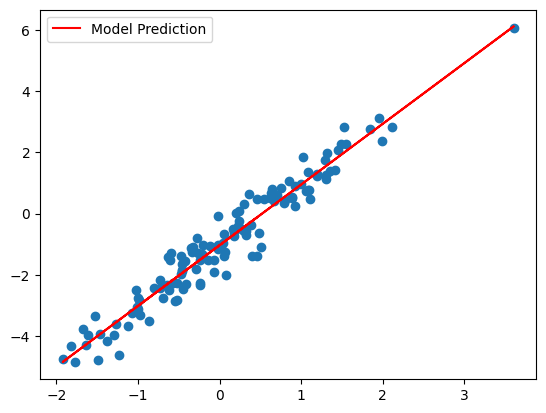

In [ ]:
from helpers import review_request, run_submitted_function, accept_request

for message in messages:
    review_request(message)
    real_result = run_submitted_function(message)
    accept_request(message, real_result)

## Part 3 - Downloading the Results

### Tutorial complete 👏

In [ ]:
result = data_scientist_client.api.services.code.counter_1()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.counter_2()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.linear_regression()
assert not isinstance(result, sy.SyftError)

---------------------------------------------------------------------------
SyftAttributeError
---------------------------------------------------------------------------
Exception: 'APIModule' api object has no submodule or method 'linear_regression', you may not have permission to access the module you are trying to access


In [ ]:
if node.node_type.value == "python":
    node.land()